# Aligning linkage maps to scaffolds

Here I will take the 17235 linkage mapped RADtags from the 9 families of RADseq, and align them to the scaffolds of the Rtemp PacBio and Optical mapping hybrid assembly. 

I will take this reasonably slowly, as we know that the assembly is extremely heterozygous, so the tags are likely to align to more than one position if that position is represented by two scaffolds in the assembly. . . 

Usually, tags will align to many different places, due to the high repeat content of the genome, so our usual criteria on which to keep an alignment if it aligns either uniquely (uncommon), or if the best hit for a given tag has an e-value which is 1e-05 better than any other hit. In this case however, we should also consider alignments where there are 2 hits which are 1e-05 better than the rest. These could represent the two scaffolds for a given region. We can then examine the tags which map to two scaffolds with high fidelity, and see if those two scaffolds are often aligned to by many tags. . . . if so, then we can keep them. Or perhaps just choose one for ALLMAPS (the one with the most hits) and manually assign the other with the same position. 

Lets go . . . 

In [1]:
from __future__ import division

import numpy as np

### Aligning RADtags to the genome

Alignment was done on the cluster. Here are the results after filtering using the usual 1e-5 e-value difference between best and 2nd best hit, and the overall 1e-20 cut off.

```
Number of multi-alingments kept: 1629
Number of unique alingments kept: 1214
Total = 2843 alignments
```

So keeping only things that mapped uniquely with an e-value of 1e-20 or lower, or things that mapped to multiple places with a clear "best" hit, we retain only 33% of our alignments. So I would like to try to improve this alignment rate to see if I can relax the filters on the alignments.


## Testing alignment filters

We have always somewhat arbitrarily used 1e-5 for the difference between the first and second hits. And 1e-20 for the overall cut off. These thresholds give good results, but may be too stringent for intra-specific data. With the linkage map, I have an opportunity to test how accurate these mappings are. The assumption is that if a scaffold has more than several tags on it, then those tags should be next to eachother on the map. If they are not, then they are probably erroneous mappings. So I can quantify the accuracy of the mappings for different filtering parameters, e.g. 1e-5, 1e-4, 1e-3 for the difference threshold etc.

First I'll define some functions to make this streamlined.

In [12]:
## Function to get the information from the linkage map

def Get_LM_info(LM_path, real_tag_IDs):
    
    LM = open(LM_path, 'r').readlines()

    Linkage_map_dict = {}
    
    print len(LM)

    for tag in LM[1:]:
        #print tag
        tag_ID = tag.split()[0]  ## remember this needs to be converted to the "real" tag_ID
        real_tag_ID = real_tag_IDs[tag_ID.strip()]
        LG = tag.split()[1]
        POS = tag.split()[2]

        Linkage_map_dict[real_tag_ID] = {}
        Linkage_map_dict[real_tag_ID]["LG"] = LG
        Linkage_map_dict[real_tag_ID]["POS"] = POS
        
    return Linkage_map_dict
        


In [1]:
def evaluate_mapping_efficiency(blast_outs_path, linkage_map_path, Genome_fasta, N_min_mappings, evalue_thresh, best_hit_criteria):
    
    from collections import Counter
    import operator

    
    ## filter blast hits
    
    window = 2000
    get_frags = 0
    verb = 1

    Kept_blast_records = MISC.BlastParseExtra(blast_outs_path, Genome_fasta, best_hit_criteria, evalue_thresh, get_frags, window, 1)

    ## Get linkage map information
    
    Linkage_map_dict = Get_LM_info(linkage_map_path, real_tag_IDs)
    
    ## compile alignment and linkage mapping info for each tag into a single dictionary

    Blast_plus_LM_info = {}

    for tag in Kept_blast_records:
        if tag in Linkage_map_dict:
            Blast_plus_LM_info[tag] = {}
            Blast_plus_LM_info[tag]["scaff"] = Kept_blast_records[tag]["Ref_hit_id"]
            Blast_plus_LM_info[tag]["STRT"] = Kept_blast_records[tag]["Hit_start_coord"]
            Blast_plus_LM_info[tag]["LG"] = Linkage_map_dict[tag]["LG"]
            Blast_plus_LM_info[tag]["POS"] = Linkage_map_dict[tag]["POS"]
    
    
    ## get per scaffold information
    
    scaff_dict = {}
    for record in Blast_plus_LM_info:
        if Blast_plus_LM_info[record]["scaff"] not in scaff_dict:
            scaff_dict[Blast_plus_LM_info[record]["scaff"]] = {}
            scaff_dict[Blast_plus_LM_info[record]["scaff"]][record] = {}
            scaff_dict[Blast_plus_LM_info[record]["scaff"]][record]["LG"] = Blast_plus_LM_info[record]["LG"]
            scaff_dict[Blast_plus_LM_info[record]["scaff"]][record]["POS"] = Blast_plus_LM_info[record]["POS"]
        else:
            scaff_dict[Blast_plus_LM_info[record]["scaff"]][record] = {}
            scaff_dict[Blast_plus_LM_info[record]["scaff"]][record]["LG"] = Blast_plus_LM_info[record]["LG"]
            scaff_dict[Blast_plus_LM_info[record]["scaff"]][record]["POS"] = Blast_plus_LM_info[record]["POS"]

    
    ## keep only scaffolds with <N_min_mappings> hits
    
    scaff_dict_kept = {}

    for scaff in scaff_dict:
        if len(scaff_dict[scaff]) >= N_min_mappings:
            scaff_dict_kept[scaff] = scaff_dict[scaff]
            

    ## Now count the number of LOCI that don't match the consensus LG for each scaffold
    
    N_non_consensus_loci = 0
    N_consensus_loci = 0
    
    ## get the consensus LG for each scaffold (most common LG)
    
    for scaff in scaff_dict_kept:
        LGs = []
        for record in scaff_dict_kept[scaff]:
            LGs.append(scaff_dict_kept[scaff][record]["LG"])

        LG_counts = Counter(LGs)
        consensus_LG = max(LG_counts.iteritems(), key=operator.itemgetter(1))[0]  ## the LG with the highest number of mappings to that scaffold
        N_non_consensus_markers = len(LGs) - LG_counts[consensus_LG]
        
        N_consensus_loci += LG_counts[consensus_LG]
        N_non_consensus_loci += N_non_consensus_markers
            
    ## Now count the number of different linkage groups which have been mapped to the same scaffold
    
#    consensus_values = []
#    for scaff in scaff_dict_kept:
#        LGs = []
#        for record in scaff_dict_kept[scaff]:
#            LGs.append(scaff_dict_kept[scaff][record]["LG"])
#
#        LG_counts = Counter(LGs)
#        consensus_LG = max(LG_counts.iteritems(), key=operator.itemgetter(1))[0]  ## the LG with the highest number of mappings to that scaffold
#
#   
#            
#        consensus_value = LG_counts[consensus_LG] / sum(LG_counts.values())
#
#        consensus_values.append(consensus_value)


    ### Outputs

    N_mapped_markers = len(Kept_blast_records)
    N_scaffolds_mapped_to = len(scaff_dict)
    N_scaffs_over_10 = len(scaff_dict_kept)
    #mean_consensuses = np.mean(consensus_values)
    Proportion_consensus_loci = N_consensus_loci/(N_consensus_loci+N_non_consensus_loci)
    
    
    print "Total N mapped markers:", N_mapped_markers
    print "N scaffolds mapped to:", N_scaffolds_mapped_to
    print "N scaffolds with >%s mappings: %s" % (N_min_mappings, N_scaffs_over_10)
    #print "Mean consesnsus value: %.3f" % mean_consensuses
    print "N loci on retained scaffolds: %s" % (N_consensus_loci+N_non_consensus_loci)
    print "Proportion of consensus loci: %.3f" % Proportion_consensus_loci

### Now test the mapping efficiency for parameters below:

Testing difference threshold:

```
evalue_threshold = 1e-20
best_hit_threshold = 1e-5

evalue_threshold = 1e-20
best_hit_threshold = 1e-4

evalue_threshold = 1e-20
best_hit_threshold = 1e-3

evalue_threshold = 1e-20
best_hit_threshold = 1e-2
```

Testing absolute e-value threshold:

```
evalue_threshold = 1e-18
best_hit_threshold = 1e-5

evalue_threshold = 1e-16
best_hit_threshold = 1e-5

evalue_threshold = 1e-14
best_hit_threshold = 1e-5
```



In [87]:
blast_outs_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/Mapped_tags_fasta/SbfI_blastouts.xml"
linkage_map_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/LepMap_Fem_linkage_map/map_20_js_19_ordered_InfMask_2_FEMALE_genetic_mapper.dat"
Genome_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
N_mappings_min = 5
evalue_threshold = 1e-20
best_hit_threshold = 1e-5

evaluate_mapping_efficiency(blast_outs_path, linkage_map_path, Genome_path, N_mappings_min, evalue_threshold, best_hit_threshold)


Number of multi-alingments kept: 1629
Number of unique alingments kept: 1214
11305
Total N mapped markers: 2843
N scaffolds mapped to: 1371
N scaffolds with >5 mappings: 116
N loci on retained scaffolds: 889
Proportion of consensus loci: 0.996


In [88]:
blast_outs_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/Mapped_tags_fasta/SbfI_blastouts.xml"
linkage_map_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/LepMap_Fem_linkage_map/map_20_js_19_ordered_InfMask_2_FEMALE_genetic_mapper.dat"
Genome_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
N_mappings_min = 5
evalue_threshold = 1e-20
best_hit_threshold = 1e-4

evaluate_mapping_efficiency(blast_outs_path, linkage_map_path, Genome_path, N_mappings_min, evalue_threshold, best_hit_threshold)


Number of multi-alingments kept: 1686
Number of unique alingments kept: 1214
11305
Total N mapped markers: 2900
N scaffolds mapped to: 1390
N scaffolds with >5 mappings: 118
N loci on retained scaffolds: 904
Proportion of consensus loci: 0.996


In [89]:
blast_outs_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/Mapped_tags_fasta/SbfI_blastouts.xml"
linkage_map_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/LepMap_Fem_linkage_map/map_20_js_19_ordered_InfMask_2_FEMALE_genetic_mapper.dat"
Genome_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
N_mappings_min = 5
evalue_threshold = 1e-20
best_hit_threshold = 1e-3

evaluate_mapping_efficiency(blast_outs_path, linkage_map_path, Genome_path, N_mappings_min, evalue_threshold, best_hit_threshold)


Number of multi-alingments kept: 2197
Number of unique alingments kept: 1214
11305
Total N mapped markers: 3411
N scaffolds mapped to: 1610
N scaffolds with >5 mappings: 136
N loci on retained scaffolds: 1073
Proportion of consensus loci: 0.993


In [90]:
blast_outs_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/Mapped_tags_fasta/SbfI_blastouts.xml"
linkage_map_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/LepMap_Fem_linkage_map/map_20_js_19_ordered_InfMask_2_FEMALE_genetic_mapper.dat"
Genome_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
N_mappings_min = 5
evalue_threshold = 1e-20
best_hit_threshold = 1e-2

evaluate_mapping_efficiency(blast_outs_path, linkage_map_path, Genome_path, N_mappings_min, evalue_threshold, best_hit_threshold)


Number of multi-alingments kept: 2440
Number of unique alingments kept: 1214
11305
Total N mapped markers: 3654
N scaffolds mapped to: 1711
N scaffolds with >5 mappings: 149
N loci on retained scaffolds: 1170
Proportion of consensus loci: 0.989


In [91]:
blast_outs_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/Mapped_tags_fasta/SbfI_blastouts.xml"
linkage_map_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/LepMap_Fem_linkage_map/map_20_js_19_ordered_InfMask_2_FEMALE_genetic_mapper.dat"
Genome_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
N_mappings_min = 5
evalue_threshold = 1e-20
best_hit_threshold = 1e-1

evaluate_mapping_efficiency(blast_outs_path, linkage_map_path, Genome_path, N_mappings_min, evalue_threshold, best_hit_threshold)


Number of multi-alingments kept: 3650
Number of unique alingments kept: 1214
11305
Total N mapped markers: 4864
N scaffolds mapped to: 2191
N scaffolds with >5 mappings: 224
N loci on retained scaffolds: 1711
Proportion of consensus loci: 0.976


In [92]:
blast_outs_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/Mapped_tags_fasta/SbfI_blastouts.xml"
linkage_map_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/LepMap_Fem_linkage_map/map_20_js_19_ordered_InfMask_2_FEMALE_genetic_mapper.dat"
Genome_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
N_mappings_min = 5
evalue_threshold = 1e-18
best_hit_threshold = 1e-5

evaluate_mapping_efficiency(blast_outs_path, linkage_map_path, Genome_path, N_mappings_min, evalue_threshold, best_hit_threshold)


Number of multi-alingments kept: 1630
Number of unique alingments kept: 1214
11305
Total N mapped markers: 2844
N scaffolds mapped to: 1372
N scaffolds with >5 mappings: 116
N loci on retained scaffolds: 889
Proportion of consensus loci: 0.996


In [93]:
blast_outs_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/Mapped_tags_fasta/SbfI_blastouts.xml"
linkage_map_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/LepMap_Fem_linkage_map/map_20_js_19_ordered_InfMask_2_FEMALE_genetic_mapper.dat"
Genome_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
N_mappings_min = 5
evalue_threshold = 1e-16
best_hit_threshold = 1e-5

evaluate_mapping_efficiency(blast_outs_path, linkage_map_path, Genome_path, N_mappings_min, evalue_threshold, best_hit_threshold)


Number of multi-alingments kept: 1631
Number of unique alingments kept: 1220
11305
Total N mapped markers: 2851
N scaffolds mapped to: 1374
N scaffolds with >5 mappings: 116
N loci on retained scaffolds: 890
Proportion of consensus loci: 0.996


In [94]:
blast_outs_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/Mapped_tags_fasta/SbfI_blastouts.xml"
linkage_map_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Meitriele_Linkage_map/LepMap_Fem_linkage_map/map_20_js_19_ordered_InfMask_2_FEMALE_genetic_mapper.dat"
Genome_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rana_PB_OM_SCAFFOLDED_and_NOT_SCAFFOLDED_concat.fasta"
N_mappings_min = 5
evalue_threshold = 1e-14
best_hit_threshold = 1e-5

evaluate_mapping_efficiency(blast_outs_path, linkage_map_path, Genome_path, N_mappings_min, evalue_threshold, best_hit_threshold)


Number of multi-alingments kept: 1633
Number of unique alingments kept: 1223
11305
Total N mapped markers: 2856
N scaffolds mapped to: 1377
N scaffolds with >5 mappings: 116
N loci on retained scaffolds: 891
Proportion of consensus loci: 0.994


## Lets plot these results

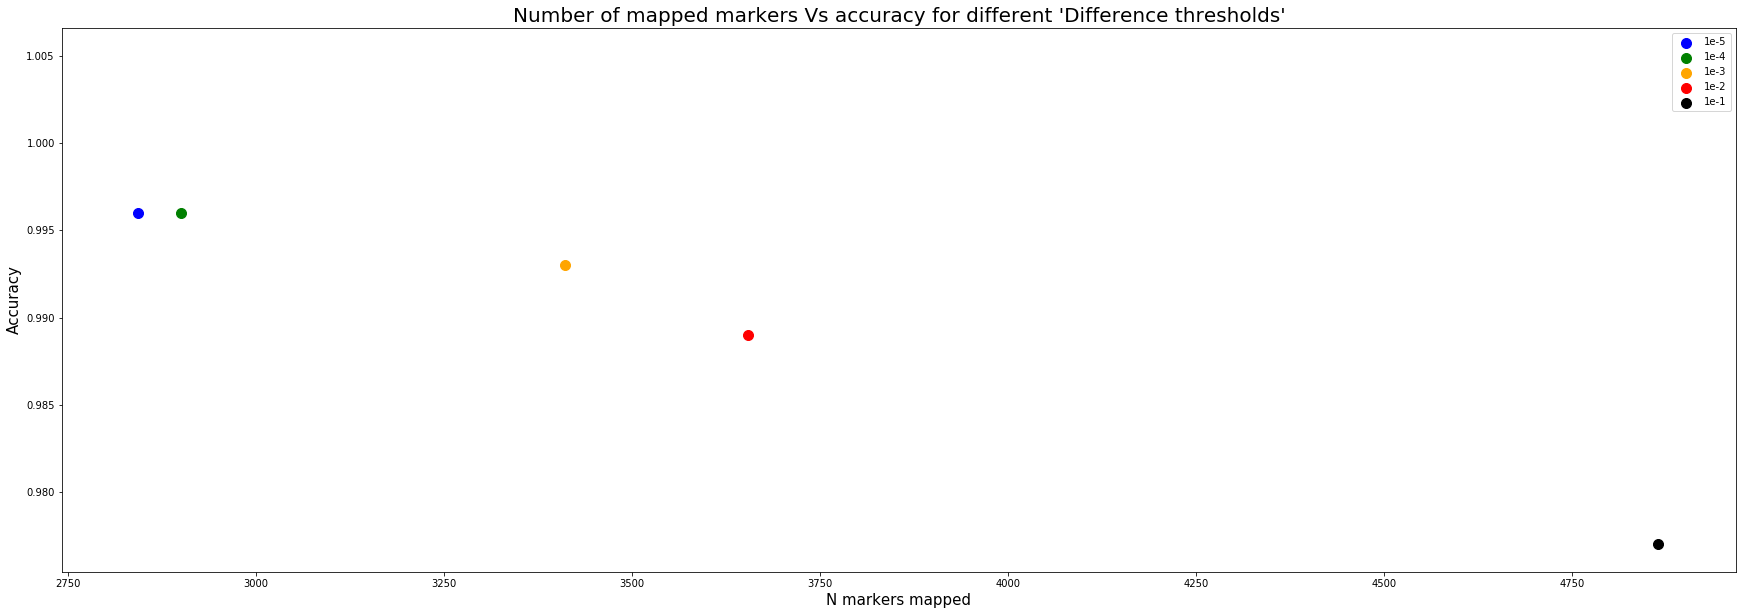

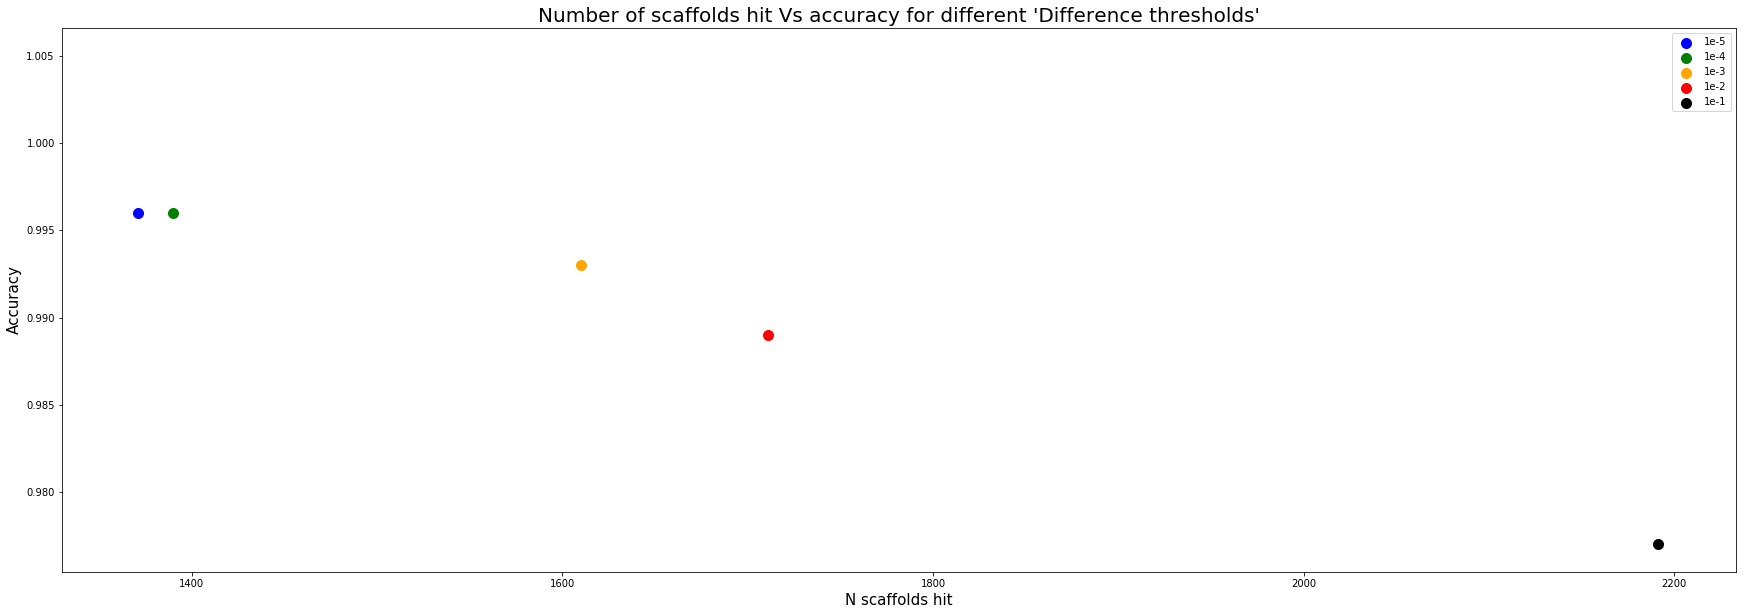

In [97]:
Threshold = ["1e-5","1e-4","1e-3","1e-2","1e-1"]
colours = ["blue","green","orange","red","black"]
N_mapped_markers = [2843,2900,3411,3654,4864]
N_scaffolds_hit = [1371,1390,1610,1711,2191]
Accuracy = [0.996,0.996,0.993,0.989,0.976]

fig = plt.figure(figsize=(30,10))
for i in range(5):
    plt.scatter(N_mapped_markers[i], Accuracy[i], c=colours[i], label = Threshold[i], s = 100)

plt.title("Number of mapped markers Vs accuracy for different 'Difference thresholds'", fontsize = 20)
plt.xlabel("N markers mapped", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)

plt.legend()
plt.show()

fig = plt.figure(figsize=(30,10))
for i in range(5):
    plt.scatter(N_scaffolds_hit[i], Accuracy[i], c=colours[i], label = Threshold[i], s = 100)

plt.title("Number of scaffolds hit Vs accuracy for different 'Difference thresholds'", fontsize = 20)
plt.xlabel("N scaffolds hit", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)

plt.legend()
plt.show()


## Summary

So it looks like the abosolute e-value doesn't do much. Its the threshold difference that does the most. And its surprising how low I can go with it. Even using 1e-1 difference, the rate of consensus is still 97.6%. So how significant is a 2.4% error rate? That means that, on a scaffold with 100 tags, 2-3 of them will be wrongly mapped. In this case though ALLMAPS would surely anchor them correctly. But of course, most scaffolds are too small to have this number, some will have just one or two mappings. In those with just one, about 2.4% of them will be wrongly ordered. Which isn't ideal. 

Given that the real drop in accuracy doesn't occur until we go from 1e-3 down to 1e-2, I will stick with the 1e-3 threshold going forward into the final marker mappings. Notice that this retains >1000 extra scaffolds! A pretty worthwhile test afterall! 
